# Load data, define model

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

# Set parameters

In [2]:
exp = 'Vienna_5DataSets_1.1_deep' # must be available in the models folder

#### Define data folder ####

subject = 'Vol5' # must exist inside data folder

# Load data and masks

In [3]:
#Define parameters 

#### Load data and brain mask ####

data = np.load('../data/'+subject+'/OriginalData/data.npy')

spectra = np.fft.fftshift(np.fft.fft(data, axis=-1), axes=-1)

# load brain mask:
brainmask = np.load('../data/'+subject+'/masks/brain_mask.npy')

#### Load lipid mask ####
skmask = np.load('../data/'+subject+'/masks/lipid_mask.npy')

# transpose to match naiming conventions of bernis pipeline
spectra = spectra.transpose(1,0,2,3)
brainmask = brainmask.transpose(1,0,2)
skmask = skmask.transpose(1,0,2)

headmask = brainmask + skmask 

In [4]:
import os
import sys

model_dir = os.path.abspath(f'../models/{exp}')
src_dir   = os.path.abspath(f'../src')

sys.path.insert(0, model_dir)
sys.path.insert(0, src_dir)
#pip install h5py nibabel pandas glob2 regex

import numpy as np
import nibabel as nib
import h5py
import time
from joblib import Parallel, delayed
from tqdm import tqdm
from itertools import product
import scipy
import torch
import torch.nn as nn
os.environ["CUDA_VISIBLE_DEVICES"]= '1' #, this way I would choose GPU 3 to do the work
import scipy.io as sio
from lipidRemoval import *

# compute lipid projection / lipid removal operator

In [5]:
import numpy as np

# ------------------------------------------------------------------
# 1)  Daten vorbereiten  
T        = spectra.shape[-1]                 # 960
Data_rf  = spectra.reshape(-1, T)            # (Nvox, 960)
lipid_rf = Data_rf[skmask.flatten() > 0, :]  # scalp-Voxels

#2)  β bestimmen und Operatoren berechnen
beta, M = find_beta_bisect(lipid_rf)          # garantiert konvergent
RemOP   = np.linalg.inv(np.eye(T) + beta * M)
LipidRem_Operator_ff  = RemOP
LipidProj_Operator_ff = np.eye(T) - RemOP

print(f"Achieved diag-mean = {np.mean(np.abs(np.diag(RemOP))):.4f} at β = {beta:.2e}")


Achieved diag-mean = 0.9377 at β = 4.92e-06


In [6]:
# ——————————— Example usage ———————————
if __name__ == "__main__":
    # 1) Prepare device & experiment name
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # 4) Run lipid removal
    Data_LipidRemoved_rrrf = runNNLipRemoval2(
        device,
        exp,
        spectra,
        LipidProj_Operator_ff,
        headmask,
        batch_size=200
    )

[runNNLipRemoval2] done in 7.6s


In [7]:
Nuisance_Free_FID_Data = np.fft.ifft(np.fft.ifftshift(Data_LipidRemoved_rrrf, axes=-1), axis=-1) # go back to FID domain

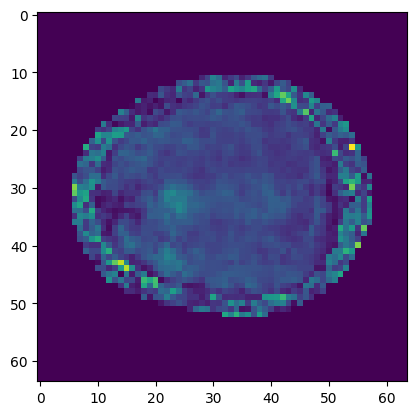

In [8]:
z, t = 20, 4

Slice = np.abs(Nuisance_Free_FID_Data)[:,:,z,t]
plt.imshow(Slice)

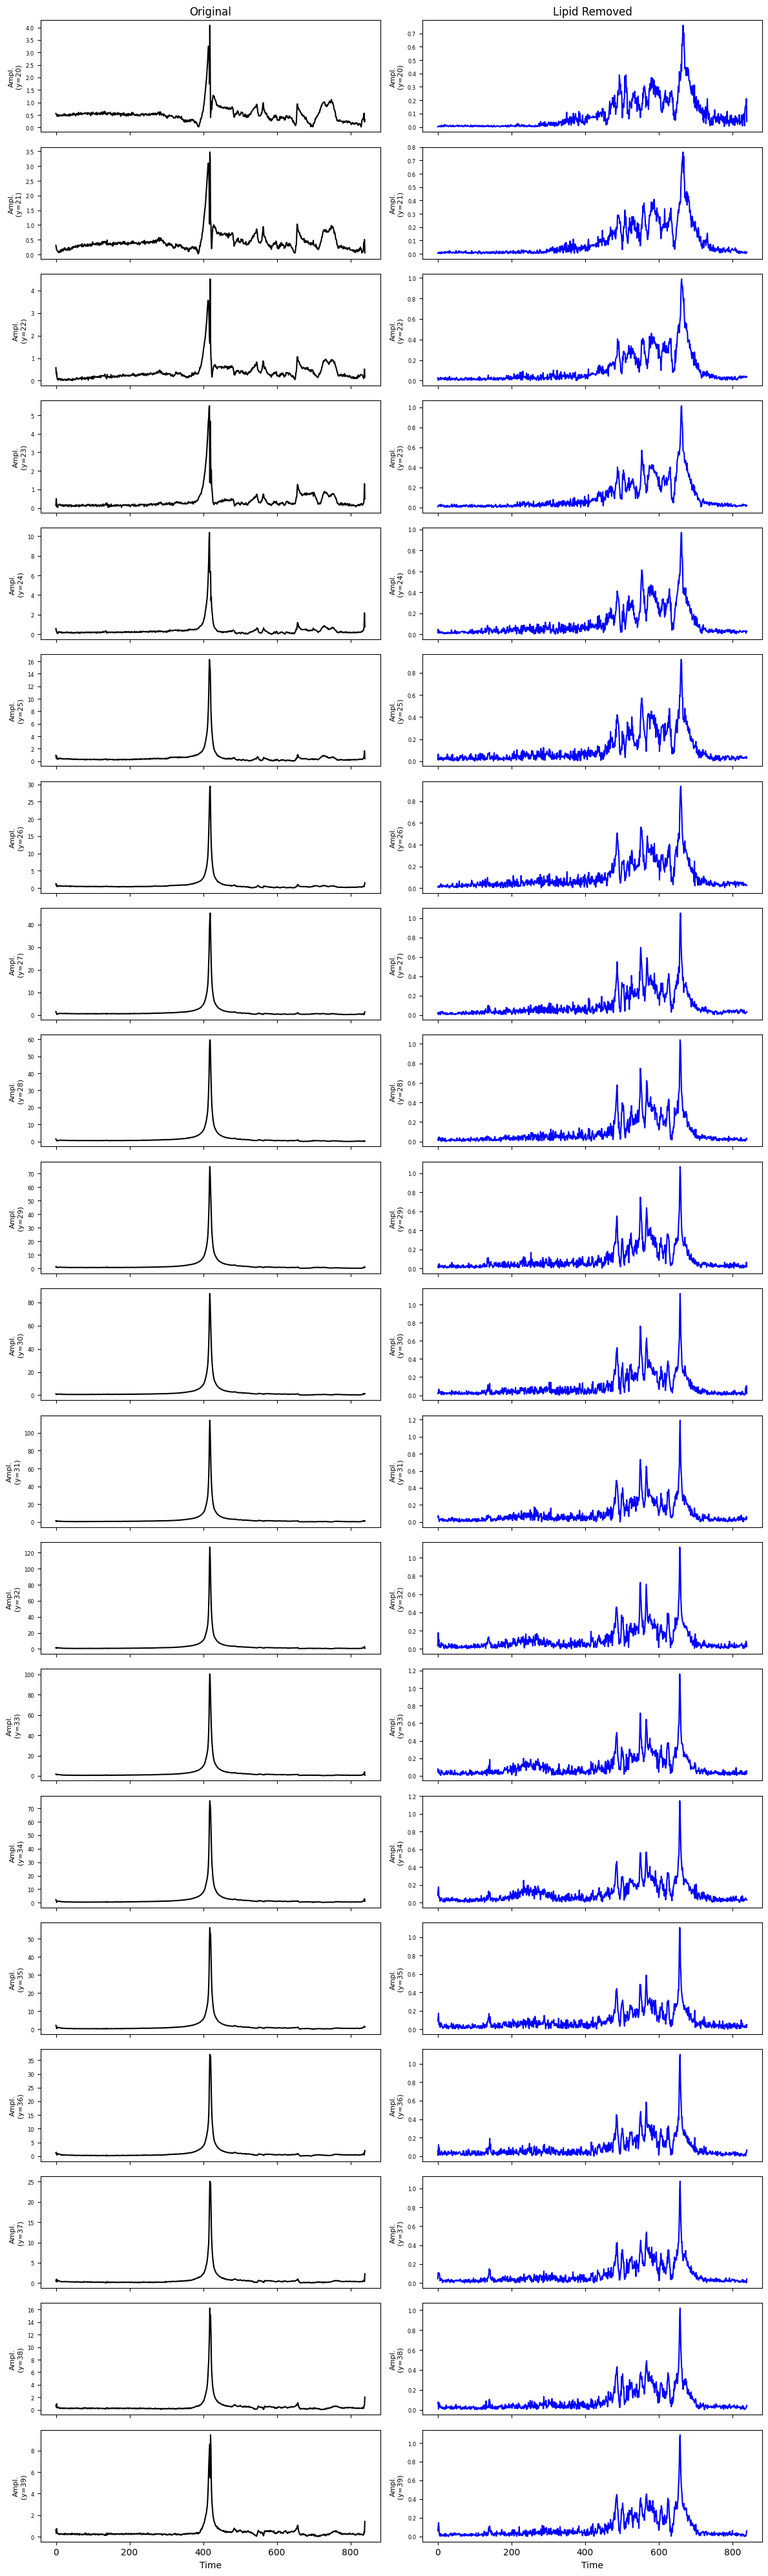

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Example arrays — replace with your actual data
# Data               = np.load("data.npy")
Data_LipidRemoved  = np.abs(Data_LipidRemoved_rrrf)
Data = np.abs(np.fft.fftshift(np.fft.fft(data, axis=-1), axes=-1))

# Parameters
x = 32
z = 20
y_vals = np.arange(20, 40)  # 20 rows

# Create figure
fig, axs = plt.subplots(nrows=len(y_vals), ncols=2, figsize=(12, 2 * len(y_vals)), sharex=True)

for i, y in enumerate(y_vals):
    # Original
    axs[i, 0].plot(Data[x, y, z, :], color='black')
    axs[i, 0].set_ylabel(f'Ampl.\n(y={y})', fontsize=8)
    axs[i, 0].tick_params(axis='y', labelsize=6)

    # Lipid-removed
    axs[i, 1].plot(Data_LipidRemoved[x, y, z, :], color='blue')
    axs[i, 1].set_ylabel(f'Ampl.\n(y={y})', fontsize=8)
    axs[i, 1].tick_params(axis='y', labelsize=6)

# Column titles
axs[0, 0].set_title("Original")
axs[0, 1].set_title("Lipid Removed")

# X-labels only for the last row
axs[-1, 0].set_xlabel("Time")
axs[-1, 1].set_xlabel("Time")

plt.tight_layout()
plt.show()
